In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import cv2
from math import sqrt
from timeit import default_timer as timer
%matplotlib inline

In [2]:
class Point2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        
    def to_array(self):
        return np.array([x, y])

In [3]:
class Point:
    def __init__(self, x, y, z):
        self.x = x
        self.y = y
        self.z = z
        
    def __str__(self):
        return '({}, {}, {})'.format(self.x, self.y, self.z)
    
    def add(self, other):
        return Point(self.x + other.x, self.y + other.y, self.z + other.z)
    
    def sub(self, other):
        return Point(self.x - other.x, self.y - other.y, self.z - other.z)
    
    def to_array(self):
        return np.array([self.x, self.y, self.z])
    
    def projectYZ(self):
        return Point2D(self.y, self.z)

In [4]:
class Line:
    def __init__(self, p1 : Point2D, p2 : Point2D):
        self.A = p1.y - p2.y
        self.B = p2.x - p1.x
        self.C = - (self.A * p1.x + self.B * p1.y)
        l = sqrt(self.A**2 + self.B**2)
        self.A, self.B, self.C = self.A / l, self.B / l, self.C / l
        
    def dist_to(self, p : Point2D):
        return self.A * p.x + self.B * p.y + self.C

In [5]:
class Plane:
    def __init__(self, p1 : Point, p2 : Point, p3 : Point):
        v12 = p2.sub(p1)
        v13 = p3.sub(p1)
        normale = np.cross(v12.to_array(), v13.to_array())
        self.A, self.B, self.C = normale
        self.D = -np.dot(normale, p1.to_array())
        l = sqrt(self.A**2 + self.B**2 + self.C**2)
        if self.B < 0:
            l = -l
        self.A, self.B, self.C, self.D = self.A / l, self.B / l, self.C / l, self.D / l
        
    def dist_to(self, p : Point):
        return self.A * p.x + self.B * p.y + self.C * p.z + self.D

In [6]:
def filter_points(points : np.array):
    ys = np.array([p.y for p in points])
    mean_y = np.min(ys) + (np.max(ys) - np.min(ys))*0.2
    return points[ys < mean_y]

In [7]:
def find_floor_2d(points):
    startTime = timer()
    y_mins = {}
    for point in points:
        if (not point.z in y_mins) or (point.y < y_mins[point.z].y):
            y_mins[point.z] = point
    y_min_points = np.array(list(y_mins.values()))
    y_min_points = filter_points(y_min_points)
    
    eps = 70
    iters = 50

    floor_line = None
    floor_points = []

    for _ in range(iters):
        p1 = y_min_points[np.random.randint(len(y_min_points))]
        p2 = y_min_points[np.random.randint(len(y_min_points))]
        if p1 == p2:
            continue
        line = Line(p1.projectYZ(), p2.projectYZ())
        line_points = []
        for p in y_min_points:
            dist = line.dist_to(p.projectYZ())
            if abs(dist) < eps:
                line_points.append(p)
        if len(line_points) > len(floor_points):
            floor_line = line
            floor_points = line_points
    
    min_points_as_array = np.array([p.to_array() for p in y_min_points])
    floor_points_as_array = np.array([p.to_array() for p in floor_points])
    plt.figure(figsize=(5, 5))
    plt.scatter(min_points_as_array[:, 2], min_points_as_array[:, 1], s=3, c='b')
    plt.scatter(floor_points_as_array[:, 2], floor_points_as_array[:, 1], s=3, c='y')
    plt.legend(['no floor', 'floor'])
    
    floor_points = []
    for p in points:
        dist = floor_line.dist_to(p.projectYZ())
        if abs(dist) < eps:
            floor_points.append(p)
    
    endTime = timer()
    print('2d version time: {:.2f} ms'.format((endTime-startTime)*1000))
    return floor_points

In [8]:
def find_floor_3d(points):
    startTime = timer()
    y_mins = {}
    for point in points:
        if not point.x in y_mins:
            y_mins[point.x] = {}
        if (not point.z in y_mins[point.x]) or (point.y < y_mins[point.x][point.z].y):
            y_mins[point.x][point.z] = point
    y_min_points = np.array([y_mins[x][z] for x in y_mins.keys() for z in y_mins[x].keys()])
    y_min_points = filter_points(y_min_points)
    
    eps = 35
    iters = 20
    threshold = -100

    floor_plane = None
    floor_points = []

    it = 0
    while it < iters or floor_plane == None:
        it += 1
        p1 = y_min_points[np.random.randint(len(y_min_points))]
        p2 = y_min_points[np.random.randint(len(y_min_points))]
        p3 = y_min_points[np.random.randint(len(y_min_points))]
        if p1 == p2 or p1 == p3 or p2 == p3:
            continue
        plane = Plane(p1, p2, p3)
        plane_points = []
        correct = True
        for p in y_min_points:
            dist = plane.dist_to(p)
            if abs(dist) < eps:
                plane_points.append(p)
            elif dist < threshold:
                correct = False
                break
        if not correct:
            continue
        if len(plane_points) > len(floor_points):
            floor_plane = plane
            floor_points = plane_points
    
    not_floor_points = []
    for p in y_min_points:
        dist = plane.dist_to(p)
        if abs(dist) >= eps:
            not_floor_points.append(p)
    not_floor_points_as_array = np.array([p.to_array() for p in not_floor_points])
    floor_points_as_array = np.array([p.to_array() for p in floor_points])
    fig = plt.figure(figsize=(10, 10))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('X')
    ax.set_ylabel('Z')
    ax.set_zlabel('Y')
    ax.legend(['not floor', 'floor'])
    ax.scatter(not_floor_points_as_array[:, 0], not_floor_points_as_array[:, 2], not_floor_points_as_array[:, 1], s=1, c='b')
    ax.scatter(floor_points_as_array[:, 0], floor_points_as_array[:, 2], floor_points_as_array[:, 1], s=1, c='y')
    
    floor_points = []
    for p in points:
        dist = floor_plane.dist_to(p)
        if abs(dist) < eps:
            floor_points.append(p)
    
    endTime = timer()
    print('3d version time: {:.2f} ms'.format((endTime-startTime)*1000))
    return floor_points

In [9]:
def solve(img, points, floor_func : callable):
    floor_points = floor_func(points)
    floor_mask = np.zeros_like(img)
    for p in floor_points:
        xp = int(320 + p.x / p.z * 575.7)
        yp = int(240 - p.y / p.z * 575.7)
        floor_mask[yp][xp] = 65535
    return floor_mask

In [10]:
def get_points(img):
    y_proj, x_proj = img.nonzero()
    z_proj = img[y_proj, x_proj]
    x_real = ((x_proj - 320) / 575.7 * z_proj).astype(np.int64)
    y_real = ((240 - y_proj) / 575.7 * z_proj).astype(np.int64)
    z_real = z_proj.astype(np.int64)
    n_points = len(x_real)
    points = [Point(x_real[i], y_real[i], z_real[i]) for i in range(n_points)]
    return points

2d version time: 1035.58 ms
3d version time: 2301.48 ms
Total processing time: 4429.25 ms
2d version time: 790.16 ms
3d version time: 1271.19 ms
Total processing time: 3102.57 ms
2d version time: 911.17 ms
3d version time: 1382.03 ms
Total processing time: 3163.12 ms
2d version time: 672.09 ms
3d version time: 1694.74 ms
Total processing time: 3383.98 ms
2d version time: 1017.27 ms
3d version time: 2168.60 ms
Total processing time: 4304.77 ms
2d version time: 876.97 ms
3d version time: 2636.73 ms
Total processing time: 4965.47 ms
2d version time: 972.76 ms
3d version time: 3451.26 ms


/opt/conda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Total processing time: 6120.52 ms


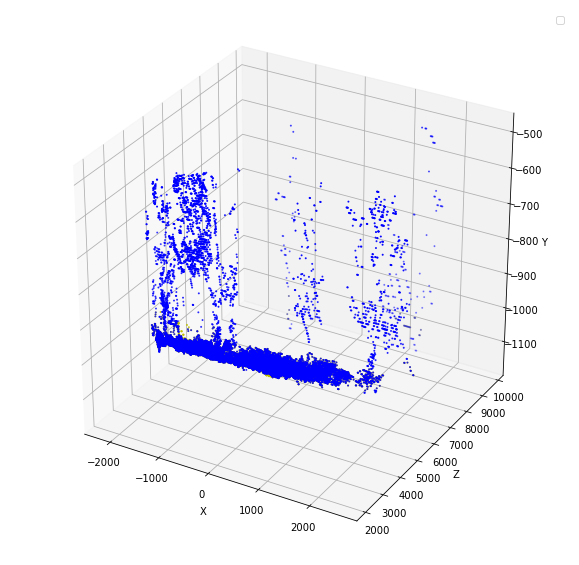

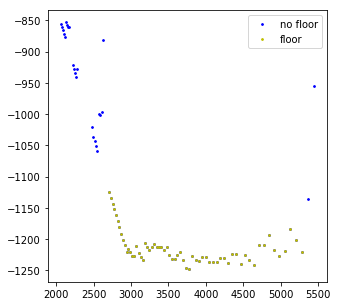

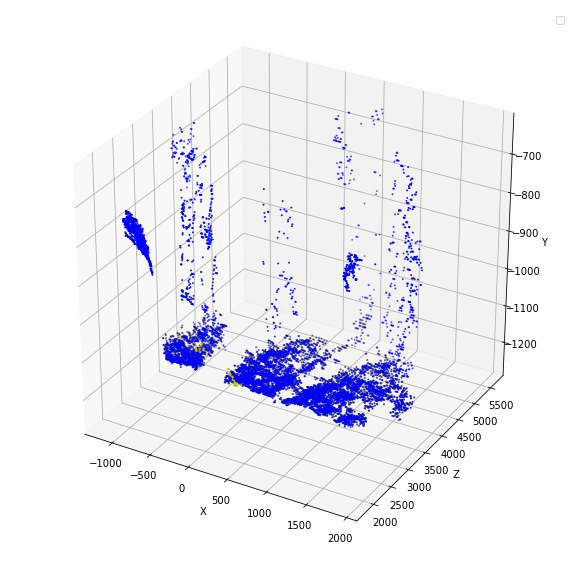

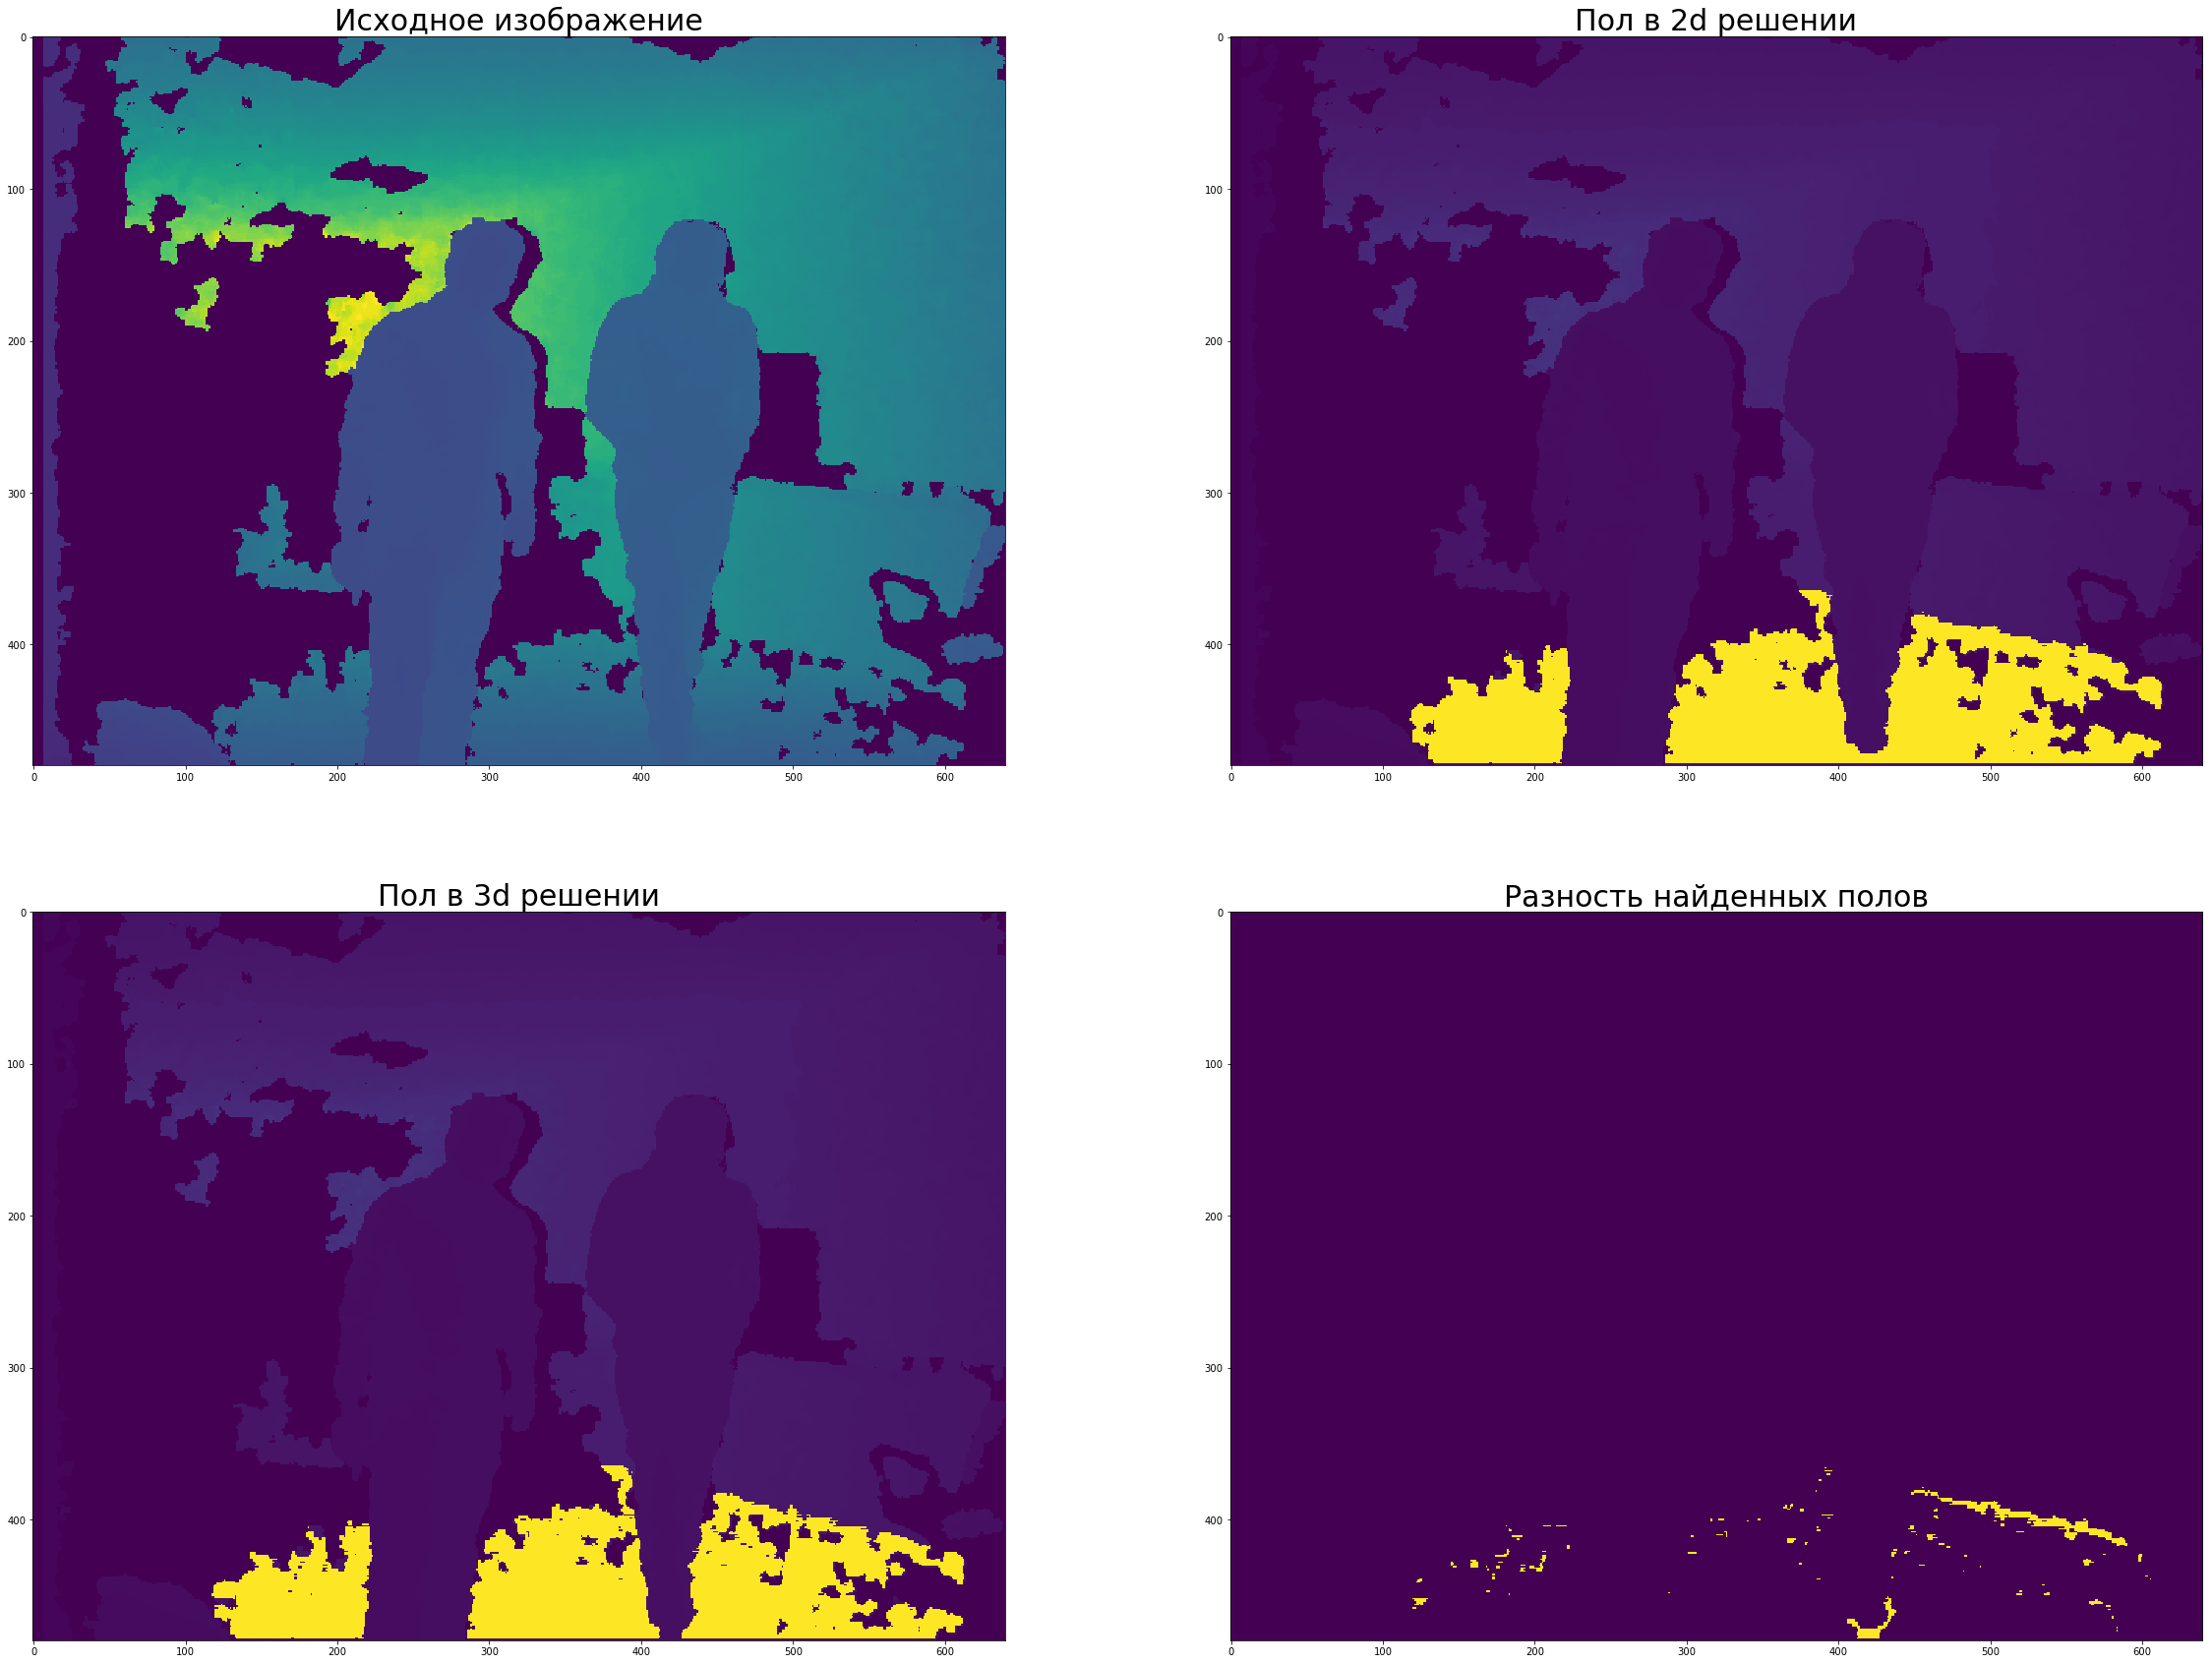

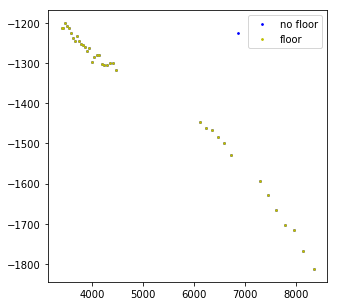

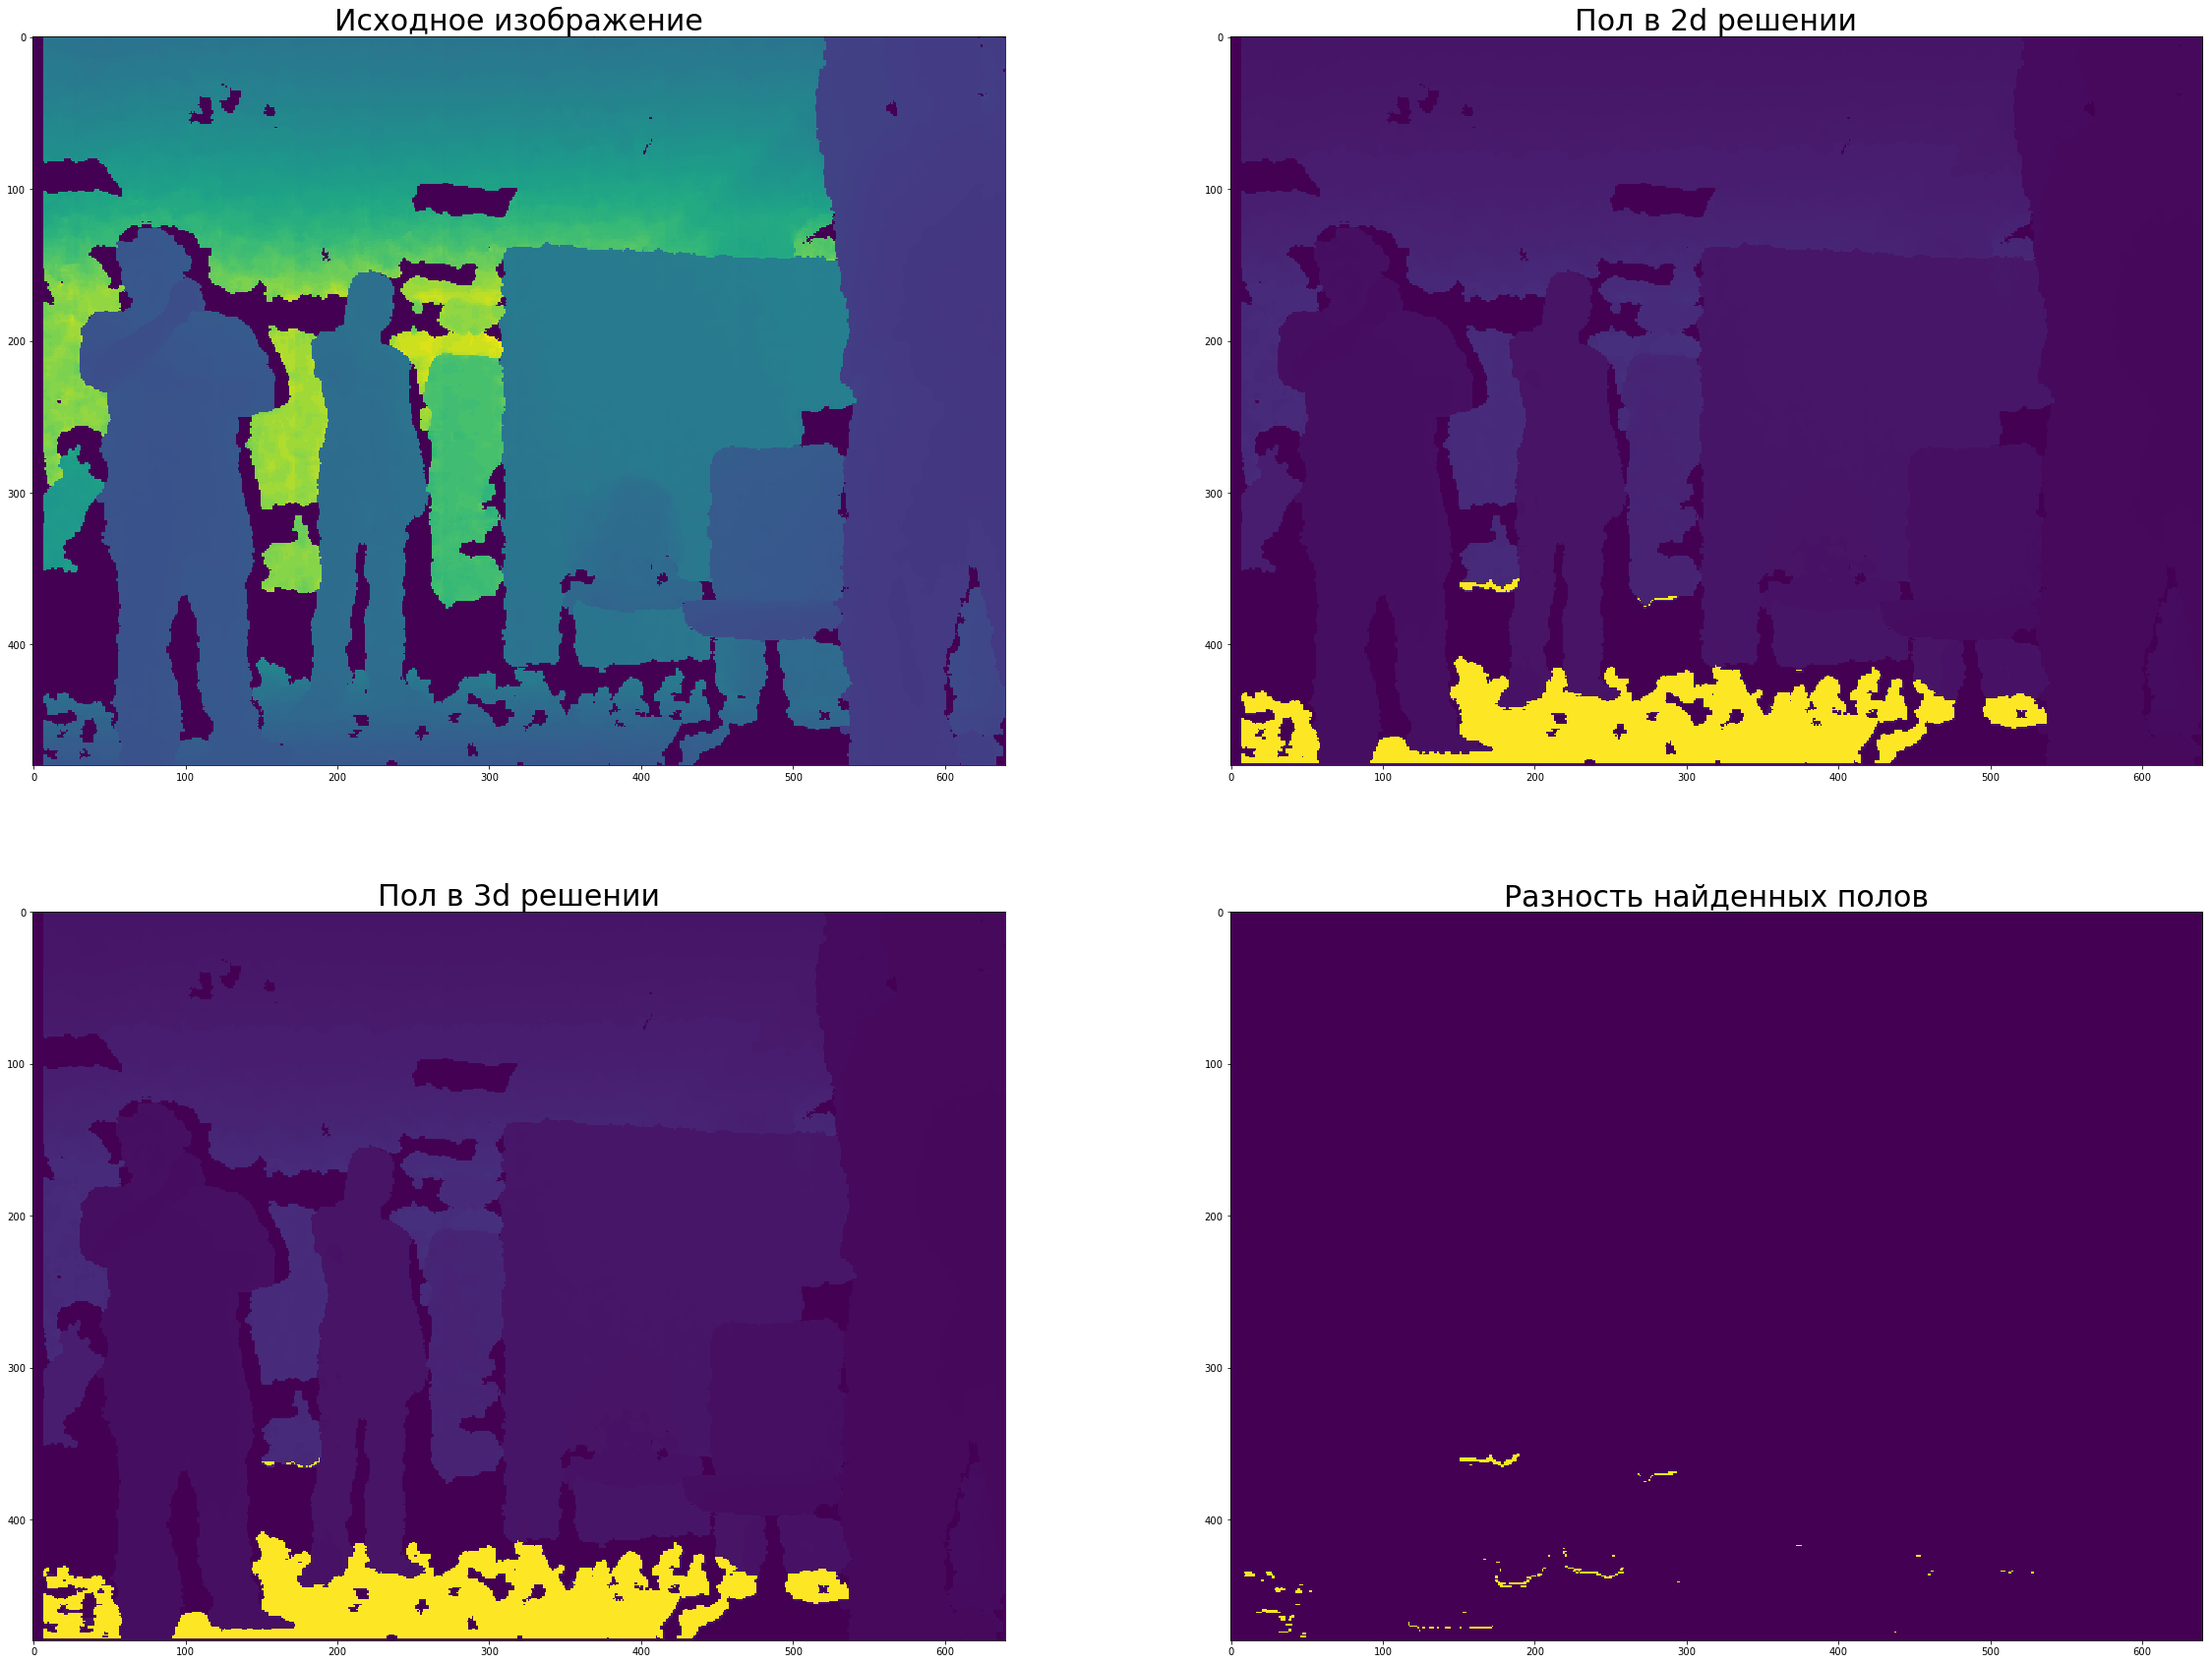

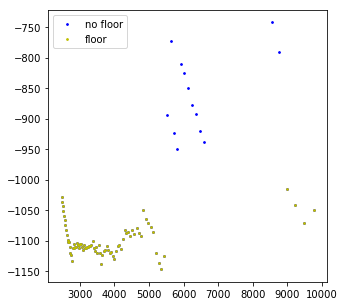

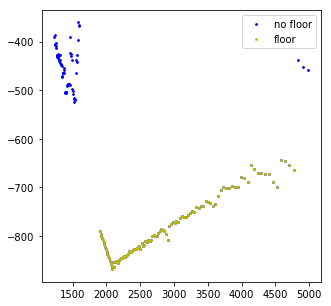

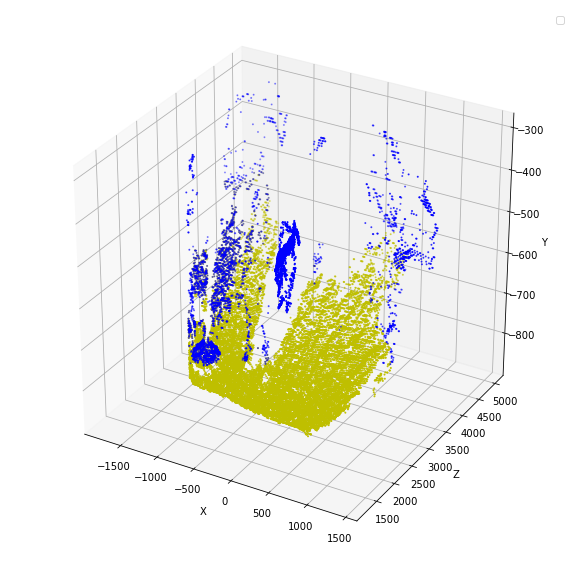

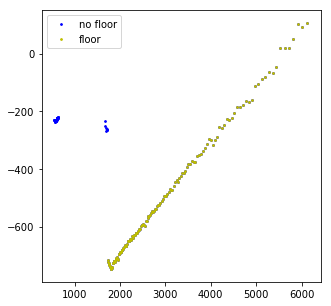

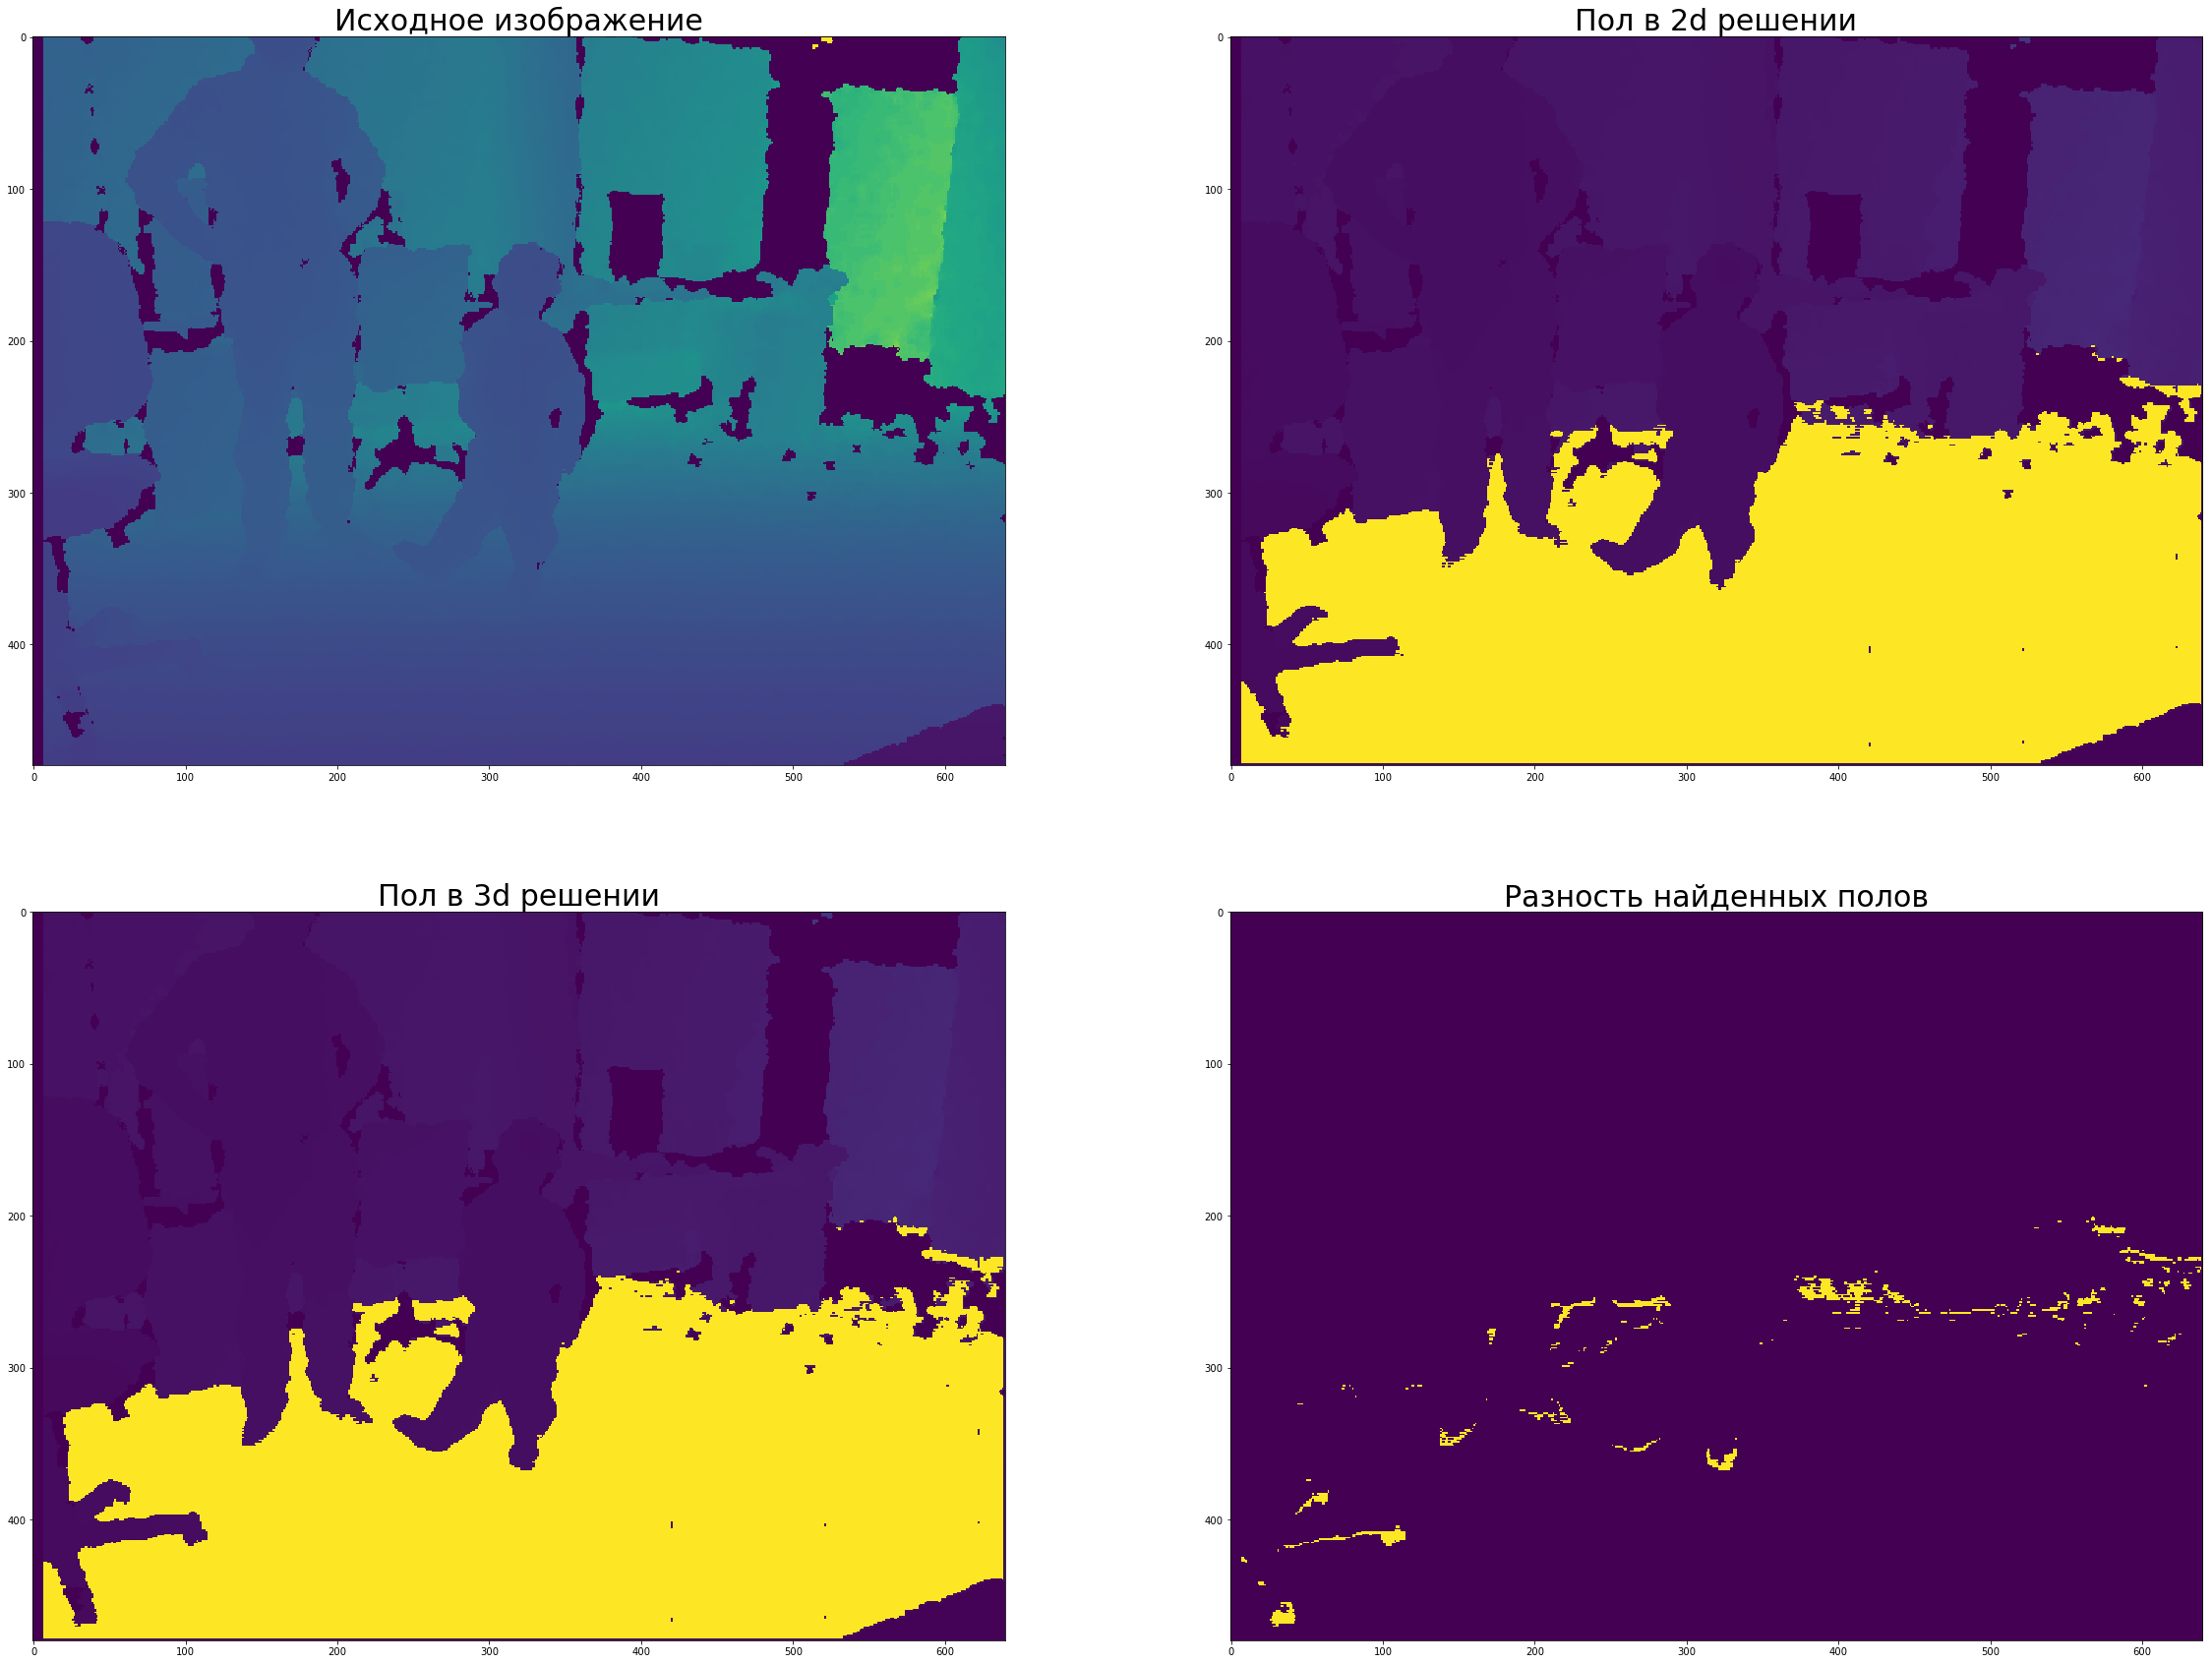

In [12]:
for i in range(1, 8):
    totalStartTime = timer()
    img = cv2.imread('./data/task2/{}.png'.format(i), cv2.IMREAD_UNCHANGED)
    points = get_points(img)
    floor_mask_2d = solve(img, points, floor_func=find_floor_2d)
    floor_mask_3d = solve(img, points, floor_func=find_floor_3d)
    plt.figure(figsize=(40, 30))
    plt.subplot(221)
    plt.title('Исходное изображение', fontsize=30)
    plt.imshow(img)
    plt.subplot(222)
    plt.title('Пол в 2d решении', fontsize=30)
    plt.imshow(np.bitwise_or(img, floor_mask_2d))
    plt.subplot(223)
    plt.title('Пол в 3d решении', fontsize=30)
    plt.imshow(np.bitwise_or(img, floor_mask_3d))
    plt.subplot(224)
    plt.title('Разность найденных полов', fontsize=30)
    plt.imshow(np.bitwise_xor(floor_mask_2d, floor_mask_3d))
    totalEndTime = timer()
    print('Total processing time: {:.2f} ms'.format((totalEndTime - totalStartTime)*1000))
    